## model try


### Load libraries

In [1]:
from cv2 import cv2
import os
import json
import time

import pathlib
from torch.utils.data import DataLoader
import sys
sys.path.append('../')
from src.data.my_dataset import XRayDataSet
from src.data.my_dataset import collate_fn
from tqdm import tqdm

#for model
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
import torch

In [4]:
dataset = XRayDataSet(pathlib.Path('../literature/Other/supervisely/wrist'))

In [5]:
training_dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4,collate_fn=collate_fn)

In [6]:
images , targets = next(iter(training_dataloader))

In [7]:
targets

([{'boxes': tensor([[494., 901., 518., 934.],
           [320., 559., 449., 635.],
           [173., 546., 282., 615.]]),
   'labels': tensor([2, 1, 1]),
   'image_id': tensor([75]),
   'area': [792, 9804, 7521],
   'iscrowd': tensor([0, 0, 0,  ..., 0, 0, 0])}],)

In [8]:
def get_model_instance_segmentation(num_classes):
      
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [9]:
model = get_model_instance_segmentation(3)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [10]:
model.train()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [11]:
loss_dict = model(images[0], targets[0]) 
losses = sum(loss for loss in loss_dict.values())

In [12]:
losses

tensor(1.6571, grad_fn=<AddBackward0>)

In [13]:
model.eval()
x = torch.rand(1, 3, 600, 1200) #[torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

In [27]:
#dummy boxes and images format
images, boxes = torch.rand(1, 3, 600, 1200), torch.rand(1, 2, 4) 
labels = torch.randint(1, 91, (1, 2))
images = list(image for image in images)
targets = []
for i in range(len(images)):
    d = {}
    d['boxes'] = boxes[i]
    d['labels'] = labels[i]
    targets.append(d)

tensor([[[[0.6504, 0.5623, 0.1097,  ..., 0.8406, 0.8715, 0.7249],
          [0.6987, 0.7536, 0.0747,  ..., 0.3365, 0.0969, 0.0686],
          [0.3993, 0.8877, 0.4036,  ..., 0.2031, 0.1325, 0.8784],
          ...,
          [0.7262, 0.4426, 0.9398,  ..., 0.3797, 0.2326, 0.9332],
          [0.0456, 0.6236, 0.3564,  ..., 0.8387, 0.4192, 0.5564],
          [0.6244, 0.2570, 0.2527,  ..., 0.9619, 0.0989, 0.9304]],

         [[0.8101, 0.4914, 0.0718,  ..., 0.2938, 0.3306, 0.8811],
          [0.1357, 0.6016, 0.0756,  ..., 0.5653, 0.5589, 0.5067],
          [0.0147, 0.8641, 0.1535,  ..., 0.6922, 0.9939, 0.9593],
          ...,
          [0.6033, 0.0272, 0.7831,  ..., 0.5305, 0.7837, 0.7600],
          [0.1120, 0.1405, 0.8196,  ..., 0.4158, 0.2649, 0.8206],
          [0.8421, 0.6788, 0.9737,  ..., 0.0908, 0.9850, 0.6511]],

         [[0.6998, 0.1557, 0.8465,  ..., 0.3918, 0.4306, 0.0219],
          [0.4011, 0.5885, 0.6939,  ..., 0.6980, 0.4858, 0.2516],
          [0.8277, 0.2561, 0.6150,  ..., 0

In [28]:
predictions

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)}]

## Real try of the Model

In [23]:
#keep only predictions with score higher than the threshold
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [24]:
dataset = XRayDataSet(pathlib.Path('../literature/Other/supervisely/wrist'))
training_dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4,collate_fn=collate_fn)

In [33]:
model = get_model_instance_segmentation(3)

In [34]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

num_epochs = 3

In [35]:
print('----------------------train started--------------------------')

for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in tqdm(training_dataloader):
        i += 1
        #print(annotations)
        #imgs = list(img.to(device) for img in imgs)
        #annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

        #print(annotations)


        loss_dict = model(imgs[0], annotations[0]) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

print('----------------------train ended--------------------------')

----------------------train started--------------------------


  0%|          | 0/10 [00:27<?, ?it/s]


KeyboardInterrupt: 

In [28]:
#save the model state
torch.save(model.state_dict(),f'my_first_model.pt')


In [36]:
#load the model state
model = get_model_instance_segmentation(3)
model.load_state_dict(torch.load(f'my_first_model.pt'))


<All keys matched successfully>

In [76]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img,cmap='gray')
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx].detach().numpy()

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        print(type(rect))
        ax.add_patch(rect)

    plt.show()

In [29]:
#make a single prediction based on the train
with torch.no_grad(): 
    # batch size of the test set = 2
    for imgs, annotations in training_dataloader:
        #imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs[0], 0.1)
        print(pred)
        break

[{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}]


In [37]:
model.eval()
images , targets = next(iter(training_dataloader))
predictions = model(images[0])

In [62]:
targets

([{'boxes': tensor([[645.,  86., 690., 152.],
           [210., 661., 335., 731.],
           [404., 699., 474., 777.]]),
   'labels': tensor([2, 1, 1]),
   'image_id': tensor([4]),
   'area': [2970, 8750, 5460],
   'iscrowd': tensor([0, 0, 0,  ..., 0, 0, 0])}],)

In [38]:
predictions

[{'boxes': tensor([[646.9323,  96.6301, 689.1317, 167.8360],
          [639.2880,  75.2391, 683.7845, 148.1036]], grad_fn=<StackBackward0>),
  'labels': tensor([2, 2]),
  'scores': tensor([0.0524, 0.0500], grad_fn=<IndexBackward0>)}]

Target :  tensor([2, 1, 1])
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>


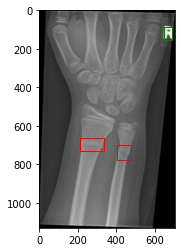

In [77]:
print("Target : ",targets[0][0]['labels'])
plot_image_from_output(images[0][0], targets[0][0])

Prediction :  tensor([2, 2])
<class 'matplotlib.patches.Rectangle'>
<class 'matplotlib.patches.Rectangle'>


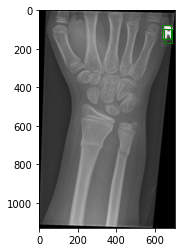

In [78]:
print("Prediction : ", predictions[0]['labels'])
plot_image_from_output(images[0][0],predictions[0])

In [72]:
predictions[0]['boxes'].detach().numpy()


array([[646.93225,  96.63005, 689.13165, 167.83595],
       [639.28796,  75.23912, 683.78455, 148.10364]], dtype=float32)